Reproducing some scaling laws results from [Chinchilla](https://arxiv.org/pdf/2203.15556.pdf). Can't get the numbers to match exactly, but can still be used as a rough guide to help determine compute-optimal models. Also contains related utilities for calculating flops and param counts.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## params

First some parameter calculations:

In [2]:
def gpt_params(seq_len, vocab_size, d_model, num_heads, num_layers):
    """ Given GPT config calculate total number of parameters """
    ffw_size = 4*d_model # in GPT the number of intermediate features is always 4*d_model
    # token and position embeddings
    embeddings = d_model * vocab_size + d_model * seq_len
    # transformer blocks
    attention = 3*d_model**2 + 3*d_model # weights and biases
    attproj = d_model**2 + d_model
    ffw = d_model*(ffw_size) + ffw_size
    ffwproj = ffw_size*d_model + d_model
    layernorms = 2*2*d_model
    # dense
    ln_f = 2*d_model
    dense = d_model*vocab_size # note: no bias here
    # note: embeddings are not included in the param count!
    total_params = num_layers*(attention + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    return total_params

gpt2 = dict(seq_len = 1024, vocab_size = 50257, d_model = 768, num_heads = 12, num_layers = 12)
gpt_params(**gpt2)/1e6

123.653376

OpenAI reports gpt2 (small) as having 124M params, so this is a match. Also, loading the OpenAI weights into nanoGPT and then calling `model.parameters()` exactly matches the above number and verifies the implementation. Now Chinchilla parameters:

In [3]:
def chinchilla_params(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size):
    """ Parameters in the Chinchilla models. Unlike GPT they use relative positional embeddings. """
    # token embeddings only
    embeddings = d_model * vocab_size
    # transformer blocks
    attention = 3*d_model**2 + 3*d_model # weights and biases
    relative_pos = d_model**2 + 2*d_model # relative keys, content bias, relative bias
    attproj = d_model**2 + d_model
    ffw = d_model*ffw_size + ffw_size
    ffwproj = ffw_size*d_model + d_model
    layernorms = 2*2*d_model
    # dense
    ln_f = 2*d_model
    dense = d_model*vocab_size # note: no bias here
    # note: embeddings are not included in the param count!
    total_params = num_layers*(attention + relative_pos + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    return total_params



In [4]:
# Load in all the 50 Chinchilla models on the last page of the paper
import json
chinchilla_models_txt = '[[44000000.0, 512, 2048, 64, 8, 8], [57000000.0, 576, 2304, 64, 9, 9], [74000000.0, 640, 2560, 64, 10, 10], [90000000.0, 640, 2560, 64, 10, 13], [106000000.0, 640, 2560, 64, 10, 16], [117000000.0, 768, 3072, 64, 12, 12], [140000000.0, 768, 3072, 64, 12, 15], [163000000.0, 768, 3072, 64, 12, 18], [175000000.0, 896, 3584, 64, 14, 14], [196000000.0, 896, 3584, 64, 14, 16], [217000000.0, 896, 3584, 64, 14, 18], [251000000.0, 1024, 4096, 64, 16, 16], [278000000.0, 1024, 4096, 64, 16, 18], [306000000.0, 1024, 4096, 64, 16, 20], [425000000.0, 1280, 5120, 128, 10, 18], [489000000.0, 1280, 5120, 128, 10, 21], [509000000.0, 1408, 5632, 128, 11, 18], [552000000.0, 1280, 5120, 128, 10, 24], [587000000.0, 1408, 5632, 128, 11, 21], [632000000.0, 1536, 6144, 128, 12, 19], [664000000.0, 1408, 5632, 128, 11, 24], [724000000.0, 1536, 6144, 128, 12, 22], [816000000.0, 1536, 6144, 128, 12, 25], [893000000.0, 1792, 7168, 128, 14, 20], [1018000000.0, 1792, 7168, 128, 14, 23], [1143000000.0, 1792, 7168, 128, 14, 26], [1266000000.0, 2048, 8192, 128, 16, 22], [1424000000.0, 2176, 8704, 128, 17, 22], [1429000000.0, 2048, 8192, 128, 16, 25], [1593000000.0, 2048, 8192, 128, 16, 28], [1609000000.0, 2176, 8704, 128, 17, 25], [1731000000.0, 2304, 9216, 128, 18, 24], [1794000000.0, 2176, 8704, 128, 17, 28], [2007000000.0, 2304, 9216, 128, 18, 28], [2283000000.0, 2304, 9216, 128, 18, 32], [2298000000.0, 2560, 10240, 128, 20, 26], [2639000000.0, 2560, 10240, 128, 20, 30], [2980000000.0, 2560, 10240, 128, 20, 34], [3530000000.0, 2688, 10752, 128, 22, 36], [3802000000.0, 2816, 11264, 128, 22, 36], [4084000000.0, 2944, 11776, 128, 22, 36], [4516000000.0, 3072, 12288, 128, 24, 36], [6796000000.0, 3584, 14336, 128, 28, 40], [9293000000.0, 4096, 16384, 128, 32, 42], [11452000000.0, 4352, 17408, 128, 32, 47], [12295000000.0, 4608, 18432, 128, 36, 44], [12569000000.0, 4608, 18432, 128, 32, 47], [13735000000.0, 4864, 19456, 128, 32, 47], [14940000000.0, 4992, 19968, 128, 32, 49], [16183000000.0, 5120, 20480, 128, 40, 47]]'
chilchilla_models = json.loads(chinchilla_models_txt) # all 50 models
chilchilla_models[0] # tuples of params, d_model, ffw_size, kv_size, n_heads, n_layers from Table A9

[44000000.0, 512, 2048, 64, 8, 8]

In [5]:
for m in chilchilla_models[-5:]: # only print last 5 models of the table
    p, d, f, k, h, l = m
    nparams = chinchilla_params(seq_len = 1024, vocab_size = 32000, d_model = d, num_heads = h, num_layers = l, ffw_size=f)
    print(f"our estimated params: {nparams/1e6:.4f}M, chinchilla params: {p/1e6:.4f}M, d_model: {d}, n_heads: {h}, n_layers: {l}")

our estimated params: 12296.1623M, chinchilla params: 12295.0000M, d_model: 4608, n_heads: 36, n_layers: 44
our estimated params: 13124.4826M, chinchilla params: 12569.0000M, d_model: 4608, n_heads: 32, n_layers: 47
our estimated params: 14614.4279M, chinchilla params: 13735.0000M, d_model: 4864, n_heads: 32, n_layers: 47
our estimated params: 16037.5039M, chinchilla params: 14940.0000M, d_model: 4992, n_heads: 32, n_layers: 49
our estimated params: 16184.4582M, chinchilla params: 16183.0000M, d_model: 5120, n_heads: 40, n_layers: 47


We are almost able to reproduce the parameter counts for the Chinchilla models.

Now turning to FLOPs:

## flops

In [6]:
def chinchilla_flops(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size):
    """ 
    Calculate total number of FLOPs, see Chinchilla 
    paper Appendix F as reference: https://arxiv.org/pdf/2203.15556.pdf
    """ 
    key_size = d_model // num_heads

    # embeddings
    embeddings = 2 * seq_len * vocab_size * d_model

    # attention
    # key, query, value projections
    attention = 2 * 3 * seq_len * d_model * (key_size * num_heads)
    # key @ query logits
    attlogits = 2 * seq_len * seq_len * (key_size * num_heads)
    # softmax
    attsoftmax = 3 * num_heads * seq_len * seq_len # 3* is for subtract (max), exp, divide (?)
    # softmax @ value reductions
    attvalue = 2 * seq_len * seq_len * (key_size * num_heads)
    # final linear
    attlinear = 2 * seq_len * (key_size * num_heads) * d_model
    att = attention + attlogits + attsoftmax + attvalue + attlinear
    # feed forward
    dense = 2 * seq_len * (d_model * ffw_size + d_model * ffw_size)

    # logits
    logits = 2 * seq_len * d_model * vocab_size
    
    # this is what you'd expect:
    # forward_flops = embeddings + num_layers * (att + dense) + logits
    # but:
    # per author correspondence apparently there is typo in the paper,
    # they do not count embeddings and logits to repro table 4. So instead:
    forward_flops = num_layers * (att + dense)
    backward_flops = 2 * forward_flops # as in Kaplan et al. 2020
    total_flops = forward_flops + backward_flops

    return total_flops


In [7]:
# Now try reproduce Table A4 from Chinchilla paper Appendix, 
# comparing accurate flops above to approximate flops F = 6*N*D
# note Chinchilla mentions using vocab_size = 32K

chilchilla_models_table4 = [
  [10, 640, 2560, 10, 64],
  [20, 1024, 4096, 16, 64],
  [24, 1280, 5120, 10, 128 ],
  [26, 1792, 7168, 14, 128 ],
  [28, 2048, 8192, 16, 128],
  [40,  3584, 14336, 28, 128]
]

rows = []
for num_layers, d_model, ffw_size, num_heads, _ in chilchilla_models_table4:

    args = dict(seq_len = 2048, vocab_size = 32000, d_model = d_model, 
                num_heads = num_heads, num_layers = num_layers, ffw_size=ffw_size)

    D = args['seq_len'] # dataset size (cancels anyway, for the purposes of the ratio calculation below)
    N = chinchilla_params(**args)
    F = chinchilla_flops(**args)

    approx_flops = 6*D*N # approximate flops
    chinch_flops = F * (float(D) / args['seq_len']) # exact flops according to Chinchilla paper calculations

    # print('---')
    # print(f"params: {N/1e6:.2f}M")
    # print(f"approx flops: {approx_flops/1e9:.2f}B")
    # print(f"chinchilla flops: {chinch_flops/1e9:.2f}B")
    # print(f"ratio (chinchilla / approx): {chinch_flops / approx_flops:.2f}")

    # first copy all keyvalues from args into out
    out = {k:v for k,v in args.items()}
    # then add the calculated values
    out['N'] = N
    out['F'] = F
    out['approx_flops'] = approx_flops
    out['chinch_flops'] = chinch_flops
    out['ratio'] = chinch_flops / approx_flops
    rows.append(out)

# make a pandas dataframe from rows
df = pd.DataFrame(rows)
df

seq_len  vocab_size  d_model  num_heads  num_layers  ffw_size           N  \
0     2048       32000      640         10          10      2560    73825280   
1     2048       32000     1024         16          20      4096   305707008   
2     2048       32000     1280         10          24      5120   552604160   
3     2048       32000     1792         14          26      7168  1143453696   
4     2048       32000     2048         16          28      8192  1593126912   
5     2048       32000     3584         28          40     14336  6796274688   

                F    approx_flops  chinch_flops     ratio  
0    929877196800    907165040640  9.298772e+11  1.025036  
1   4135248199680   3756527714304  4.135248e+12  1.100817  
2   7353453772800   6790399918080  7.353454e+12  1.082919  
3  14670316437504  14050759016448  1.467032e+13  1.044094  
4  20220437594112  19576343494656  2.022044e+13  1.032902  
5  83021046743040  83512623366144  8.302105e+13  0.994114

Pretty good match! Except the param counts are still not perfectly accurate.

## Scaling Laws: Approach 3

In their "Aproach 3", Chinchilla paper fits a function L(N,D) to approximate the final loss gives the model size and the data size. Here is the final fit:

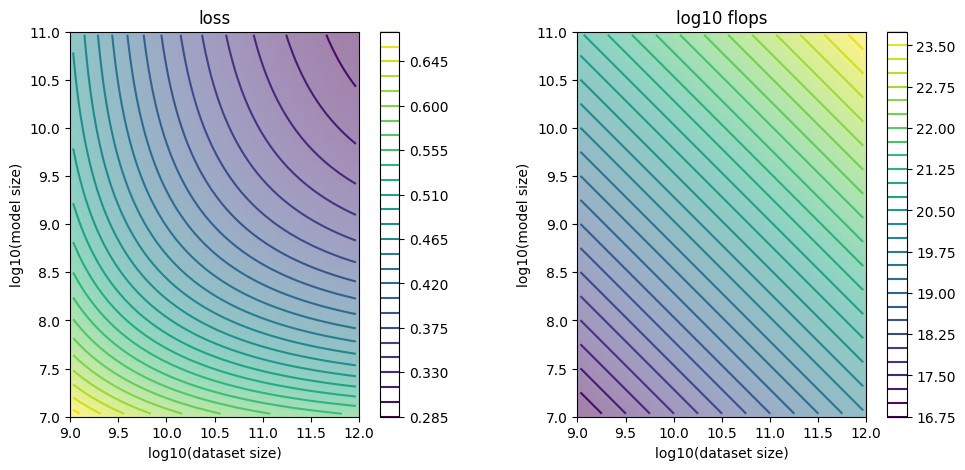

In [8]:
def L(N, D):
    """ 
    Approximates loss given N parameters and D dataset size (in tokens),
    per Chinchilla paper.
    """
    E = 1.69 # entropy of natural language, limit of infinite model on infinite data
    A = 406.4
    B = 410.7
    alpha = 0.34
    beta = 0.28
    return A / (N ** alpha) + B / (D ** beta) + E

ns = 10 ** np.arange(7, 11, step=2**-4) # model sizes from 10M to 100B
ds = 10 ** np.arange(9, 12, step=2**-4) # dataset sizes from 1B to 1T
plt.figure(figsize=(12, 5))
plt.subplot(121)
# create a 2D countour plot of loss L as a function of model size and dataset size in ns,ds
loss2d = np.log10(np.array([[L(n, d) for d in ds] for n in ns]))
plt.imshow(loss2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(loss2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('loss')
plt.colorbar()
# plot the compute for each point, which is a deterministic function: flops = 6*N*D
plt.subplot(122)
compute2d = np.log10(np.array([[6*n*d for d in ds] for n in ns]))
plt.imshow(compute2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(compute2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops')
plt.colorbar()

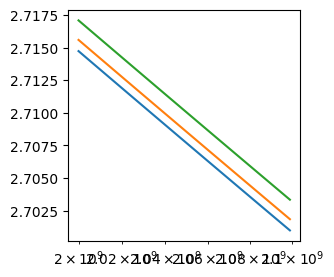

In [9]:
N1 = 100 * 10e12
N2 = 50 * 10e12
N3 = 20 * 10e12

ns = [N1, N2, N3]
D = np.arange(1000000000, 1000 * 10e9, step = 1000000)

l1 = L(N1, D)
l2 = L(N2, D)
l3 = L(N3, D)


plt.figure(figsize=(3,3))
plt.plot(D[1000:1100], l1[1000:1100])
plt.plot(D[1000:1100], l2[1000:1100])
plt.plot(D[1000:1100], l3[1000:1100])

plt.xscale('log')


In [10]:
print(l1[100:110])
print(l2[100:110])
print(l3[100:110])

[2.90086054 2.90055332 2.90024645 2.89993995 2.8996338  2.899328
 2.89902256 2.89871748 2.89841274 2.89810836]
[2.90171844 2.90141122 2.90110436 2.90079785 2.9004917  2.90018591
 2.89988047 2.89957538 2.89927064 2.89896626]
[2.90321199 2.90290477 2.90259791 2.90229141 2.90198526 2.90167946
 2.90137402 2.90106893 2.9007642  2.90045981]


In [11]:
N1 = 100 * 1e12
N2 = 50 * 1e12
N3 = 20 * 1e12

IDEAL_COMPUTE1 = 10**(m * np.log10(N1) + c)

#C_x = np.arange(10**29, IDEAL_COMPUTE1, 10**28) #10**21 * 100 # # flops

C_x = 33.4 * 10**21 * 60 * 60 * 24 * 360 * 2 # 

# Ideal dataset size of minimal loss: dataset = 10**(n * np.log10(params) + t)
IDEAL_DATASET_SIZE1 = 10**(n * np.log10(N1) + t)
# Number of flops to reach optima loss
# C = 10**(m * np.log10(params) + c)
d1 =  IDEAL_DATASET_SIZE1 * C_x /  IDEAL_COMPUTE1

IDEAL_DATASET_SIZE2 = 10**(n * np.log10(N2) + t)
IDEAL_COMPUTE2 = 10**(m * np.log10(N2) + c)
d2 = IDEAL_DATASET_SIZE2 * C_x / IDEAL_COMPUTE2

d3 = 10**(n * np.log10(N3) + t) * C_x / 10**(m * np.log10(N3) + c)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [12]:

#l1 = L(N1, d1)
#l2 = L(N2, d2)
#l3 = L(N3, d3)

#plt.figure(figsize=(8,8))
#plt.plot(C_x, l1)
#plt.plot(C_x, l2)
#plt.plot(C_x, l3)
#plt.xscale('log')

In [13]:
print(d1)
print(d2)
print(d3)

NameError: name 'd1' is not defined

In [14]:
print(IDEAL_COMPUTE1)
print(IDEAL_COMPUTE2)

NameError: name 'IDEAL_COMPUTE1' is not defined

In [15]:
print(IDEAL_DATASET_SIZE1)
print(IDEAL_DATASET_SIZE2)

NameError: name 'IDEAL_DATASET_SIZE1' is not defined

In [16]:
print(L(N1, d1))
print(L(N2, d2))
print(L(N3, d3))

NameError: name 'd1' is not defined

Ok so given any N,D we can estimate both: 1) the loss, and 2) the total flops. Now we want to solve the following problem: Given a specific budget of flops C, find: N_opt, D_opt = argmin_{FLOPs(N,D) = C} L(N, D). i.e. how big of a model should we train and for how many tokens?

best model size: 316.23M
best dataset size: 11.65B


Text(0, 0.5, 'loss')

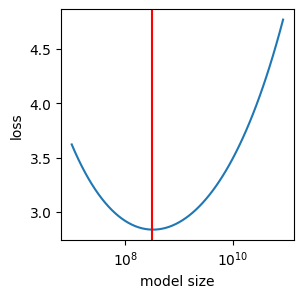

In [9]:
c = 2.21e19 # target compute budget (usually know this because we know how many GPU for how long go brrr)
# (I got this flop number from row 1 of Table A3)
# sweep model sizes from 10M to 100B
ns = 10 ** np.arange(7, 11, step=2**-4)
# using C = 6*N*D, solve for D that maintains the compute budget c
ds = c / (6 * ns)
# evaluate the loss in each case
losses = L(ns, ds)
# find the argmin
best = np.argmin(losses)
print(f"best model size: {ns[best]/1e6:.2f}M")
print(f"best dataset size: {ds[best]/1e9:.2f}B")
# plot the loss
plt.figure(figsize=(3,3))
plt.plot(ns, losses)
plt.xscale('log')
# plot a vertical bar at the best model size
plt.axvline(ns[best], color='red')
plt.xlabel('model size')
plt.ylabel('loss')

In the plot above, basically the models on the left of best are too small and trained for too long. The models on the right of best are way too large and trained for too little. The model at the red line is just right.

Now, the Chinchilla paper says that best model size for this flop budget is 400M params and 9.2B tokens (instead of 316M params and 11.65B tokens) so there is some unresolved disagreement here too...

In [10]:
# Calculate the Chinchilla optimal models for a range of compute budgets

# sweep over compute budgets from 1e17 to 1e26
cs = 10 ** np.arange(17, 26, step=2**-8)
models = []
for c in cs:
    # sweep over model sizes
    ns = 10 ** np.arange(7, 14, step=2**-8)
    # the dataset sizes that would maintain the given compute budget
    ds = c / (6 * ns)
    # losses at each point
    losses = L(ns, ds)
    # n,d for the best model
    best = np.argmin(losses)
    models.append((c, ns[best], ds[best])) # c, n, d tuple log

len(models)

2304

In [11]:
query_model_size = 400e6
ns = np.array([n for c, n, d in models])
ds = np.array([d for c, n, d in models])
# find the index of the closest model size in ns
ix = np.argmin(np.abs(ns - query_model_size))
# retrieve the corresponding params, flops, and data size
print("closest model found:")
print(f"model size: {ns[ix]/1e6:.2f}M")
print(f"dataset size: {ds[ix]/1e9:.2f}B")
print(f"flops: {6*ns[ix]*ds[ix]:e}")
print(f"loss: {L(ns[ix], ds[ix]):.2f}")

closest model found:
model size: 399.54M
dataset size: 14.43B
flops: 3.459892e+19
loss: 2.76


This should have come out as 9.2B according to Table A3 in Chinchilla paper, per my understanding of it.

## Scaling Laws: Approach 2

Approach 2 is probably my favorite one because it fixes a flop budget and runs a number of model/dataset sizes, measures the loss, fits a parabolla, and gets the minimum. So it's a fairly direct measurement of what we're after. The best way to then calculate the compute-optimal number of tokens for any given model size, as an example, is via simple interpolation.

In [18]:
# Approach 1 numbers
# # parameters, tokens
# raw = [
#     [400e6, 8e9],
#     [1e9, 20.2e9],
#     [10e9, 205.1e9],
#     [67e9, 1.5e12],
#     [175e9, 3.7e12],
#     [280e9, 5.9e12],
#     [520e9, 11e12],
#     [1e12, 21.2e12],
#     [10e12, 216.2e12],
# ]

# Approach 2 numbers
# parameters, tokens
raw = [
    [400e6, 7.7e9],
    [1e9, 20.0e9],
    [10e9, 219.5e9],
    [67e9, 1.7e12],
    [175e9, 4.3e12],
    [280e9, 7.1e12],
    [520e9, 13.4e12],
    [1e12, 26.5e12],
    [10e12, 292.0e12],
]


In [19]:
# Approach 2 numbers
# parameters, flops, tokens
raw1 = [
    [400e6, 1.84e19, 7.7e9],
    [1e9, 1.20e20, 20.0e9],
    [10e9, 1.32e22, 219.5e9],
    [67e9, 6.88e23, 1.7e12],
    [175e9, 4.54e24, 4.3e12],
    [280e9, 1.18e25, 7.1e12],
    [520e9, 4.19e25, 13.4e12],
    [1e12, 1.59e26, 26.5e12],
    [10e12, 1.75e28, 292.0e12],
]

In [20]:
raw2 = [
    [400e6, 2.21e19, 9.2e9],
    [1e9, 1.62e20, 27.1e9],
    [10e9, 2.46e22, 410.1e9],
    [67e9, 1.71e24, 4.1e12],
    [175e9, 1.26e25, 12.0e12],
    [280e9, 3.52e25, 20.1e12],
    [520e9, 1.36e26, 43.5e12],
    [1e12, 5.65e26, 94.1e12],
    [10e12, 8.55e28, 1425.5e12],
]

In [21]:
raw3 = [
    [400e6, 1.92e19, 8.0e9],
    [1e9, 1.21e20, 20.2e9],
    [10e9, 1.23e22, 205.1e9],
    [67e9, 5.76e23, 1.5e12],
    [175e9, 3.85e24, 3.7e12],
    [280e9, 9.90e24, 5.9e12],
    [520e9, 3.43e25, 11.0e12],
    [1e12, 1.27e26, 21.2e12],
    [10e12, 1.30e28, 216.2e12],
]

In [22]:
# fit a line by linear regression to the raw data
import numpy as np
x = np.array([np.log10(x[0]) for x in raw1])
y = np.array([np.log10(x[1]) for x in raw1])
z = np.array([np.log10(x[2]) for x in raw1])
A = np.vstack([x, np.ones(len(x))]).T
B = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
n, t = np.linalg.lstsq(B, z, rcond=None)[0]
print(f"tokens (y) = {m} * parameters (x) + {c}")
print(f"flops (z) = {n} * parameters (x) + {t}")

tokens (y) = 2.041032106535896 * parameters (x) + 1.7127479149735403
flops (z) = 1.0409573169995885 * parameters (x) + 0.9353887152390916


In [23]:
# fit a line by linear regression to the raw data
import numpy as np
x_2 = np.array([np.log10(x[0]) for x in raw2])
y_2 = np.array([np.log10(x[1]) for x in raw2])
z_2 = np.array([np.log10(x[2]) for x in raw2])
A_2 = np.vstack([x_2, np.ones(len(x_2))]).T
B_2 = np.vstack([x_2, np.ones(len(x_2))]).T
m_2, c_2 = np.linalg.lstsq(A_2, y_2, rcond=None)[0]
n_2, t_2 = np.linalg.lstsq(B_2, z_2, rcond=None)[0]
print(f"tokens (y) = {m_2} * parameters (x) + {c_2}")
print(f"flops (z) = {n_2} * parameters (x) + {t_2}")

tokens (y) = 2.18023516142359 * parameters (x) + 0.5933833032619349
flops (z) = 1.1794623516391356 * parameters (x) + -0.1801177508584


In [24]:
# fit a line by linear regression to the raw data
import numpy as np
x_1 = np.array([np.log10(x[0]) for x in raw3])
y_1 = np.array([np.log10(x[1]) for x in raw3])
z_1 = np.array([np.log10(x[2]) for x in raw3])
A_1 = np.vstack([x_1, np.ones(len(x_1))]).T
B_1 = np.vstack([x_1, np.ones(len(x_1))]).T
m_1, c_1 = np.linalg.lstsq(A_1, y_1, rcond=None)[0]
n_1, t_1 = np.linalg.lstsq(B_1, z_1, rcond=None)[0]
print(f"tokens (y) = {m_1} * parameters (x) + {c_1}")
print(f"flops (z) = {n_1} * parameters (x) + {t_1}")

tokens (y) = 2.007630322375992 * parameters (x) + 2.0150417073764966
flops (z) = 1.0075297226422804 * parameters (x) + 1.240792958670282


In [25]:
# Function to convert to trillions
def to_trillions(value):
    trillion = 1e12
    if value >= trillion:
        return f'{value/trillion:.1f}T'
    elif value >= billion:
        return f'{value/billion:.1f}B'
    else:
        return f'{value:.2e}'

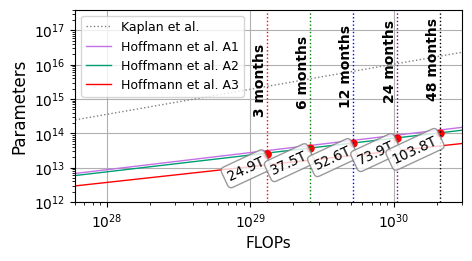

In [46]:
import copy

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Aproach 2
raw = copy.deepcopy(raw1)
raw.append([5e13, 10**(m * np.log10(5e13) + c), 10**(n * np.log10(5e13) + t)])
raw.append([1e14, 10**(m * np.log10(1e14) + c), 10**(n * np.log10(1e14) + t)])
raw.append([1e15, 10**(m * np.log10(1e15) + c), 10**(n * np.log10(1e15) + t)])
#raw.append([1e16, 10**(m * np.log10(1e16) + c), 10**(n * np.log10(1e16) + t)])
raw.insert(0, [1e6, 10**(m * np.log10(1e6) + c), 10**(n * np.log10(1e6) + t)])
raw.insert(0, [50e6, 10**(m * np.log10(50e6) + c), 10**(n * np.log10(50e6) + t)])
raw.insert(0, [100e6, 10**(m * np.log10(100e6) + c), 10**(n * np.log10(100e6) + t)])

parameters = [item[0] for item in raw]
flops = [item[1] for item in raw]
tokens = [item[2] for item in raw]

# Aproach 3

# also plot the next models
raw_2 = copy.deepcopy(raw2)
raw_2.append([5e13, 10**(m_2 * np.log10(5e13) + c_2), 10**(n_2 * np.log10(5e13) + t_2)])
raw_2.append([1e14, 10**(m_2 * np.log10(1e14) + c_2), 10**(n_2 * np.log10(1e14) + t_2)])
raw_2.append([1e15, 10**(m_2 * np.log10(1e15) + c_2), 10**(n_2 * np.log10(1e15) + t_2)])
#raw_2.append([1e16, 10**(m_2 * np.log10(1e16) + c_2), 10**(n_2 * np.log10(1e16) + t_2)])
raw_2.insert(0, [1e6, 10**(m_2 * np.log10(1e6) + c_2), 10**(n_2 * np.log10(1e6) + t_2)])
raw_2.insert(0, [50e6, 10**(m_2 * np.log10(50e6) + c_2), 10**(n_2 * np.log10(50e6) + t_2)])
raw_2.insert(0, [100e6, 10**(m_2 * np.log10(100e6) + c_2), 10**(n_2 * np.log10(100e6) + t_2)])

parameters_2 = [item[0] for item in raw_2]
flops_2 = [item[1] for item in raw_2]
tokens_2 = [item[2] for item in raw_2]

# Aproach 1

# also plot the next models
raw_1 = copy.deepcopy(raw3)
raw_1.append([5e13, 10**(m_1 * np.log10(5e13) + c_1), 10**(n_1 * np.log10(5e13) + t_1)])
raw_1.append([1e14, 10**(m_1 * np.log10(1e14) + c_1), 10**(n_1 * np.log10(1e14) + t_1)])
raw_1.append([1e15, 10**(m_1 * np.log10(1e15) + c_1), 10**(n_1 * np.log10(1e15) + t_1)])
#raw_1.append([1e16, 10**(m_1 * np.log10(1e16) + c_1), 10**(n_1 * np.log10(1e16) + t_1)])
raw_1.insert(0, [1e6, 10**(m_1 * np.log10(1e6) + c_1), 10**(n_1 * np.log10(1e6) + t_1)])
raw_1.insert(0, [50e6, 10**(m_1 * np.log10(50e6) + c_1), 10**(n_1 * np.log10(50e6) + t_1)])
raw_1.insert(0, [100e6, 10**(m_1 * np.log10(100e6) + c_1), 10**(n_1 * np.log10(100e6) + t_1)])

parameters_1 = [item[0] for item in raw_1]
flops_1 = [item[1] for item in raw_1]
tokens_1 = [item[2] for item in raw_1]

# OpenAI
flops_oai = [item[1] for item in raw]
parameters_oai = [ 1.3 * 10**9 * item ** 0.73 / ( 10 ** 15) for item in flops_oai]
tokens_oai = [item**0.27 for item in flops]


plt.figure(figsize=(5, 2.5))

plt.plot(flops, parameters_oai, label='Kaplan et al.', color='gray', linewidth=1, linestyle='dotted')
plt.plot(flops_1, parameters_1, label='Hoffmann et al. A1', color='#c371e6', linewidth=1)
plt.plot(flops, parameters, label='Hoffmann et al. A2', color='#009e73', linewidth=1)
plt.plot(flops_2, parameters_2, label='Hoffmann et al. A3', color='red', linewidth=1)


# ###################################### flops per datacenter
flops_per_datacenter = 16.8 * 10**21

# ###################################### 3 months
x_value = flops_per_datacenter * 60 * 60 * 24 * 30 * 3
# OpenAI Dot
# y_value = np.interp(x_value, flops_oai, parameters_oai)
# plt.plot(x_value, y_value, 'ro', markersize=5) 

# Approach 2
y_value = np.interp(x_value, flops_1, parameters_1)
plt.plot(x_value, y_value, 'ro', markersize=5) 

# # Approach 2
# y_value = 10**((np.log10(x_value) - c) / m)

label = to_trillions(y_value)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
plt.text(x_value, y_value, label, verticalalignment='top', horizontalalignment='right',
         bbox=bbox_props, rotation=25)

plt.plot(x_value, y_value, 'ro', markersize=5) 


plt.axvline(x=x_value, color='red', linestyle=':', linewidth=1)

padding = 0.12 * (plt.ylim()[1] - plt.ylim()[0])  # 5% of y-axis range for padding
plt.text(x_value, plt.ylim()[0] + padding, '3 months', 
         rotation=90, verticalalignment='top', horizontalalignment='right',
         fontweight='bold', fontsize=10)

##################################### 6 months
# y_value = np.interp(x_value, flops_oai, parameters_oai)
# plt.plot(x_value, y_value, 'ro', markersize=5)
x_value = flops_per_datacenter * 60 * 60 * 24 * 30 * 6


# Approach 2
y_value = 10**((np.log10(x_value) - c) / m)
plt.plot(x_value, y_value, 'ro', markersize=5) 

label = to_trillions(y_value)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
plt.text(x_value, y_value, label, verticalalignment='top', horizontalalignment='right',
         bbox=bbox_props, rotation=25)

plt.axvline(x=x_value, color='green', linestyle=':', linewidth=1)

padding = 0.17 * (plt.ylim()[1] - plt.ylim()[0])  # 5% of y-axis range for padding
plt.text(x_value, plt.ylim()[0] + padding, '6 months', 
         rotation=90, verticalalignment='top', horizontalalignment='right',
        fontweight='bold', fontsize=10)

########################################## 12 months

x_value = flops_per_datacenter * 60 * 60 * 24 * 30 * 12

# Approach 2
y_value = 10**((np.log10(x_value) - c) / m)
plt.plot(x_value, y_value, 'ro', markersize=5) 

label = to_trillions(y_value)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
plt.text(x_value, y_value, label, verticalalignment='top', horizontalalignment='right',
         bbox=bbox_props, rotation=25)

plt.axvline(x=x_value, color='blue', linestyle=':', linewidth=1)

padding = 0.3 * (plt.ylim()[1] - plt.ylim()[0])  # 5% of y-axis range for padding
plt.text(x_value, plt.ylim()[0] + padding, '12 months', 
         rotation=90, verticalalignment='top', horizontalalignment='right',
        fontweight='bold', fontsize=10)

########################################## 24 months

x_value = flops_per_datacenter * 60 * 60 * 24 * 30 * 12 * 2

# Approach 3
#y_value = np.interp(x_value, flops_1, parameters_1)
y_value = 10**((np.log10(x_value) - c) / m)

label = to_trillions(y_value)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
plt.text(x_value, y_value, label, verticalalignment='top', horizontalalignment='right',
         bbox=bbox_props, rotation=25)

plt.plot(x_value, y_value, 'ro', markersize=5)

plt.axvline(x=x_value, color='purple', linestyle=':', linewidth=1)

padding = 0.4 * (plt.ylim()[1] - plt.ylim()[0])  # 5% of y-axis range for padding
plt.text(x_value, plt.ylim()[0] + padding, '24 months', 
         rotation=90, verticalalignment='top', horizontalalignment='right',
        fontweight='bold', fontsize=10)

########################################## 48 months

x_value = flops_per_datacenter * 60 * 60 * 24 * 30 * 12 * 4

# Approach 3
#y_value = np.interp(x_value, flops_1, parameters_1)
y_value = 10**((np.log10(x_value) - c) / m)

label = to_trillions(y_value)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
plt.text(x_value, y_value, label, verticalalignment='top', horizontalalignment='right',
         bbox=bbox_props, rotation=25)

plt.plot(x_value, y_value, 'ro', markersize=5)

plt.axvline(x=x_value, color='black', linestyle=':', linewidth=1)

padding = 0.45 * (plt.ylim()[1] - plt.ylim()[0])  # 5% of y-axis range for padding
plt.text(x_value, plt.ylim()[0] + padding, '48 months', 
         rotation=90, verticalalignment='top', horizontalalignment='right',
        fontweight='bold', fontsize=10)

############################################
# x_value = 33.4 * 10**21 * 60 * 60 * 24 * 30 * 2
# # y_value = np.interp(x_value, flops_oai, parameters_oai)
# # plt.plot(x_value, y_value, 'ro', markersize=5)  # 'ro' creates a red dot
# plt.axvline(x=x_value, color='magenta', linestyle=':', linewidth=1)
# print(y_value)
# plt.text(x_value, plt.ylim()[0] + padding, '2 months', 
#          rotation=90, verticalalignment='top', horizontalalignment='right')


plt.legend(loc='upper left', fontsize=9, frameon=True)
# plot the raw data
# plt.scatter(parameters, tokens, label='Raw data', color='#3498db', s=50, alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlim(6e27, 3e30)
plt.ylim(1e12, 4e17)

plt.xlabel('FLOPs', fontsize=11)
plt.ylabel('Parameters', fontsize=12)

#plt.title('Compute for Optimal Models')
plt.grid()

# annotate with flops computation
# for i in range(len([q[0] for q in raw])):
#     plt.annotate(f'{flops[i]:.2e}', (parameters[i], tokens[i]), textcoords="offset points", xytext=(0, 0), ha='center')

# for i in range(len([q[0] for q in raw])):
#     x, y = parameters[i], tokens[i]
#     plt.annotate(f'{flops[i]:.2e}', (x, y), 
#                  textcoords="offset points", 
#                  xytext=(0, 10 if y > plt.gca().get_ylim()[0] * (plt.gca().get_ylim()[1]/plt.gca().get_ylim()[0])**0.5 else -10), 
#                  ha='center', 
#                  va='bottom' if y > plt.gca().get_ylim()[0] * (plt.gca().get_ylim()[1]/plt.gca().get_ylim()[0])**0.5 else 'top',
#                  fontsize=8,
#                  bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
plt.savefig("optimal_model_size.pdf", bbox_inches='tight')


In [27]:
### C = 519e27 # compute budget
params = 100**10*12 #10**((np.log10(C) - c) / m)
dataset = 10**(n * np.log10(params) + t)
params, C, dataset, L(params, dataset)

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log10 method

In [28]:
params = 100e12#5.244872e12
C = 10**(m * np.log10(params) + c)
dataset = 10**(n * np.log10(params) + t)
params, C, dataset, L(params, 288e12)

(100000000000000.0,
 1.937302355346794e+30,
 3226941952641007.0,
 1.7337817574755074)

# OpenAI

In [141]:
def L_OA(N, D):
    """ 
    Approximates loss given N parameters and D dataset size (in tokens),
    per OpenAI's paper. For models with a limited number of parameters,
    trained to convergence on sufficiently large datasets.
    """
    alpha_N = 0.076
    Nc = 8.8 * 10**13
    
    #return A / (N ** alpha) + B / (D ** beta) + E
    return ((Nc/N) ** (alpha_N/alpha_D) + Dc/D)**alpha_D

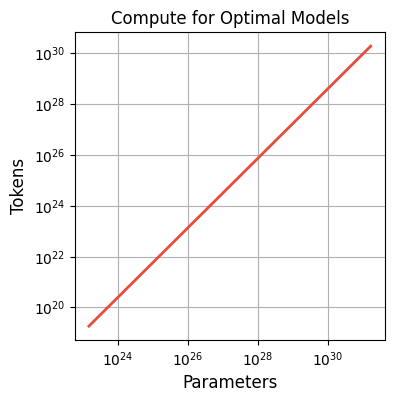

In [149]:
import copy
# also plot the next models
raw = copy.deepcopy(raw1)
raw.append([5e13, 10**(m * np.log10(5e13) + c), 10**(n * np.log10(5e13) + t)])
raw.append([1e14, 10**(m * np.log10(1e14) + c), 10**(n * np.log10(1e14) + t)])


flops = [item[1] for item in raw]
# N = (1.3 109) C ^0.73 _min
parameters = [ 1.3 * 10**9 * item ** 0.73 for item in flops]

tokens = [item**0.54 for item in flops]

plt.figure(figsize=(4, 4))

# plot the line (tokens)
plt.plot(parameters, flops, label='Linear regression', color='#e74c3c', linewidth=2)

# plot the raw data
plt.scatter(parameters, tokens, label='Raw data', color='#3498db', s=50, alpha=0.7)

plt.xscale('log')
plt.yscale('log')


plt.xlabel('Parameters', fontsize=12)
plt.ylabel('Tokens', fontsize=12)

plt.title('Compute for Optimal Models')
plt.grid()

# annotate with flops computation
# for i in range(len([q[0] for q in raw])):
#     plt.annotate(f'{flops[i]:.2e}', (parameters[i], tokens[i]), textcoords="offset points", xytext=(0, 0), ha='center')

for i in range(len([q[0] for q in raw])):
    x, y = parameters[i], tokens[i]
    plt.annotate(f'{flops[i]:.2e}', (x, y), 
                 textcoords="offset points", 
                 xytext=(0, 10 if y > plt.gca().get_ylim()[0] * (plt.gca().get_ylim()[1]/plt.gca().get_ylim()[0])**0.5 else -10), 
                 ha='center', 
                 va='bottom' if y > plt.gca().get_ylim()[0] * (plt.gca().get_ylim()[1]/plt.gca().get_ylim()[0])**0.5 else 'top',
                 fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
plt.savefig("optimal_model_size.pdf", bbox_inches='tight')


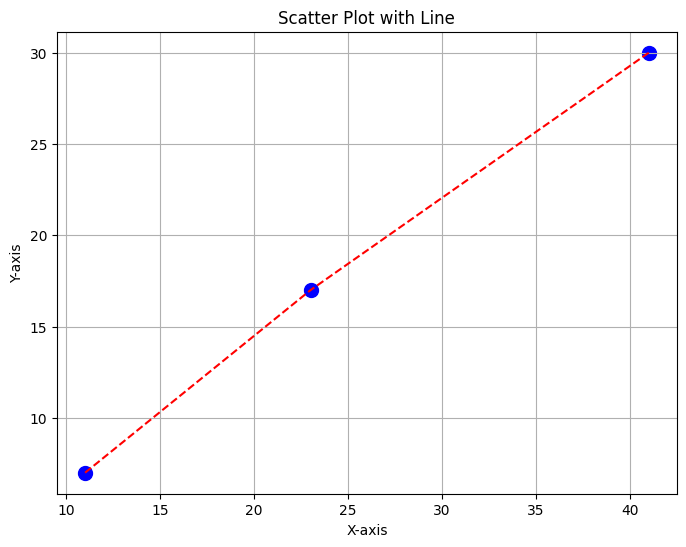

In [192]:
import matplotlib.pyplot as plt

x = [41, 23, 11]
y = [30, 17, 7]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', s=100)
plt.plot(x, y, color='red', linestyle='--')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Line')

plt.grid(True)
plt.show()